In [1]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.1')

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

# Univariate Gaussian

In [333]:
loc = 5
scale = 20
data = torch.tensor(np.random.normal(loc=loc, scale=scale, size=1000))

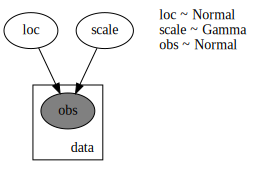

In [374]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

def model(loc_prior_params, scale_prior_params, data=None):
    loc = pyro.sample("loc", dist.Normal(loc_prior_params[0], loc_prior_params[1]))
    scale = pyro.sample("scale", dist.Gamma(scale_prior_params[0], scale_prior_params[1]))
    with pyro.plate("data", 1000):
        return pyro.sample("obs", dist.Normal(loc, scale), obs=data)
pyro.render_model(model, model_args=([0,4], [8,1], data), render_params=True, render_distributions=True)

### Train

Elbo loss: 171461.13272565336
Elbo loss: 43769.86300375968
Elbo loss: 31284.289762438784
Elbo loss: 12877.883410838185
Elbo loss: 13432.508482148194
Elbo loss: 9008.1315650388
Elbo loss: 7807.798573277209
Elbo loss: 6561.353689164332
Elbo loss: 6958.799743013207
Elbo loss: 7057.946550870711


CPU times: total: 3.11 s
Wall time: 3.71 s


Text(0, 0.5, 'ELBO loss')

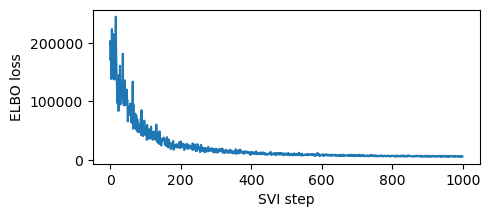

In [378]:
%%time
pyro.clear_param_store()

# These should be reset each training loop.
auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.01})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(1000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step([0,4], [8, 1], data)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [377]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.loc 1.9646636
AutoNormal.scales.loc 0.1049992
AutoNormal.locs.scale 2.1705832
AutoNormal.scales.scale 0.07601846
